# 로이터 기사 주제 분류하기
## 1. 데이터 준비하기
- Keras에 기본 포함된 로이터 데이터셋을 46개의 토픽으로 분류하는 신경망을 만든다.
- 각 데이터는 IMDB 데이터와 마찬가지로 단어와 매치되는 인덱스들의 리스트로 구성되어 있다.

In [1]:
from keras.datasets import reuters

(train_data, train_labels), (test_data, test_labels) = reuters.load_data(num_words=10000)

- 데이터가 어떻게 구성되어 있는지 확인하기 위해서 원본 텍스트로 디코딩해 본다.
- decode 과정에서 0, 1, 2는 각각 '패딩', '문서 시작', '사전에 없음'을 나타내는 인덱스이므로 3을 뺀다

In [2]:
word_index = reuters.get_word_index()
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])
decoded_newswire = ' '.join([reverse_word_index.get(i - 3, '?') for i in train_data[0]])

In [3]:
decoded_newswire

'? ? ? said as a result of its december acquisition of space co it expects earnings per share in 1987 of 1 15 to 1 30 dlrs per share up from 70 cts in 1986 the company said pretax net should rise to nine to 10 mln dlrs from six mln dlrs in 1986 and rental operation revenues to 19 to 22 mln dlrs from 12 5 mln dlrs it said cash flow per share this year should be 2 50 to three dlrs reuter 3'

- IMDB 데이터와 같은 방식으로 데이터를 벡터 형태로 변환한다.

In [4]:
import numpy as np
    
def vectorize_sequences(sequences, dimension=10000):
    results = np.zeros((len(sequences), dimension))
    for i, sequence in enumerate(sequences):
        results[i, sequence] = 1.
    return results

x_train = vectorize_sequences(train_data)
x_test = vectorize_sequences(test_data)

- Label 데이터는 one-hot 방식으로 변형하는데, keras에 내장되어 있는 to_categorical 함수를 활용해도 결과는 동일하다.

In [5]:
def to_one_hot(labels, dimension=46):
    results = np.zeros((len(labels), dimension))
    for i, label in enumerate(labels):
        results[i, label] = 1.
    return results

one_hot_train_labels = to_one_hot(train_labels)
one_hot_test_labels = to_one_hot(test_labels)

In [6]:
from keras.utils.np_utils import to_categorical

one_hot_train_labels = to_categorical(train_labels)
one_hot_test_labels = to_categorical(test_labels)

## 2. 신경망 모델 구성 및 학습
- IMDB 데이터 분류와 유사하게 relu 활성화 함수를 이용한 Dense 층들을 쌓아 모델을 구성한다.
- 46개의 토픽에 대한 확률분표를 표현하기 위해 각 층에 더 많은 파라미터와 마지막 층에 softmax 활성화 함수를 사용했다.
- 다중 분류 문제이므로 손실 함수로 categorical crossentropy 를 사용한다.

In [7]:
from keras import models, layers

model = models.Sequential()
model.add(layers.Dense(64, activation='relu', input_shape=(10000,)))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(46, activation='softmax'))

In [8]:
model.compile(optimizer='rmsprop',
             loss='categorical_crossentropy',
             metrics=['accuracy'])

In [9]:
x_val = x_train[:1000]
partial_x_train = x_train[1000:]

y_val = one_hot_train_labels[:1000]
partial_y_train = one_hot_train_labels[1000:]

In [10]:
history = model.fit(partial_x_train,
                   partial_y_train,
                   epochs=20,
                   batch_size=512,
                   validation_data=(x_val, y_val))

Epoch 1/20
16/16 [==============================] - 1s 29ms/step - loss: 2.5531 - accuracy: 0.5466 - val_loss: 1.7032 - val_accuracy: 0.6390
Epoch 2/20
16/16 [==============================] - 0s 18ms/step - loss: 1.3895 - accuracy: 0.7194 - val_loss: 1.3012 - val_accuracy: 0.7360
Epoch 3/20
16/16 [==============================] - 0s 16ms/step - loss: 1.0496 - accuracy: 0.7789 - val_loss: 1.1434 - val_accuracy: 0.7570
Epoch 4/20
16/16 [==============================] - 0s 17ms/step - loss: 0.8329 - accuracy: 0.8227 - val_loss: 1.0861 - val_accuracy: 0.7490
Epoch 5/20
16/16 [==============================] - 0s 17ms/step - loss: 0.6667 - accuracy: 0.8566 - val_loss: 1.0029 - val_accuracy: 0.7820
Epoch 6/20
16/16 [==============================] - 0s 17ms/step - loss: 0.5339 - accuracy: 0.8875 - val_loss: 0.9516 - val_accuracy: 0.8110
Epoch 7/20
16/16 [==============================] - 0s 18ms/step - loss: 0.4338 - accuracy: 0.9088 - val_loss: 0.9243 - val_accuracy: 0.8090
Epoch 8/20
16

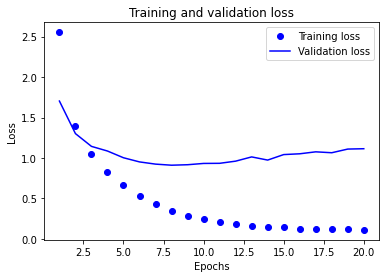

In [11]:
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

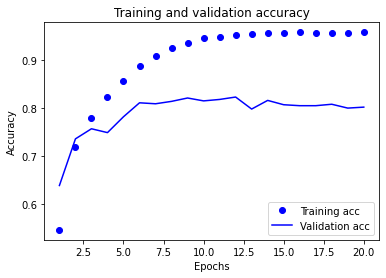

In [12]:
plt.clf()

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

- 학습 결과 약 9번째 epoch부터 더 이상 validation accuarcy 와 loss 의 향상이 일어나지 않는다.
- overfitting 을 제한하기 위해 epoch 횟수를 9로 낮춰 다시 학습을 진행한다.

In [13]:
model = models.Sequential()
model.add(layers.Dense(64, activation='relu', input_shape=(10000,)))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(46, activation='softmax'))

model.compile(optimizer='rmsprop',
             loss='categorical_crossentropy',
             metrics=['accuracy'])

history = model.fit(partial_x_train,
                   partial_y_train,
                   epochs=9,
                   batch_size=512,
                   validation_data=(x_val, y_val))

results = model.evaluate(x_test, one_hot_test_labels)
print(model.metrics_names)
print(results)

Epoch 1/9
16/16 [==============================] - 1s 35ms/step - loss: 2.6726 - accuracy: 0.5322 - val_loss: 1.7498 - val_accuracy: 0.6290
Epoch 2/9
16/16 [==============================] - 0s 17ms/step - loss: 1.4409 - accuracy: 0.7043 - val_loss: 1.3336 - val_accuracy: 0.7090
Epoch 3/9
16/16 [==============================] - 0s 18ms/step - loss: 1.0811 - accuracy: 0.7695 - val_loss: 1.1544 - val_accuracy: 0.7560
Epoch 4/9
16/16 [==============================] - 0s 17ms/step - loss: 0.8588 - accuracy: 0.8177 - val_loss: 1.0748 - val_accuracy: 0.7660
Epoch 5/9
16/16 [==============================] - 0s 18ms/step - loss: 0.6841 - accuracy: 0.8550 - val_loss: 0.9815 - val_accuracy: 0.7990
Epoch 6/9
16/16 [==============================] - 0s 17ms/step - loss: 0.5439 - accuracy: 0.8887 - val_loss: 0.9311 - val_accuracy: 0.8100
Epoch 7/9
16/16 [==============================] - 0s 17ms/step - loss: 0.4313 - accuracy: 0.9123 - val_loss: 0.9018 - val_accuracy: 0.8130
Epoch 8/9
16/16 [===

- 랜덤으로 분류할 경우 데이터셋의 불균형으로 인해 정확도가 18%밖에 안 나오는데에 비해 약 78%라는 나쁘지 않은 정확도가 나왔다.
- 새로운 데이터셋에 대한 예측 결과를 출력해 본다.

In [14]:
predictions = model.predict(x_test)
print(predictions)

[[1.6241831e-05 8.3868232e-05 1.6343863e-04 ... 1.6445450e-05
  9.7248596e-07 8.7875225e-07]
 [1.1338156e-03 2.7931141e-02 6.8981266e-03 ... 2.3916834e-04
  3.9000565e-06 1.0140047e-03]
 [2.8288404e-03 8.5281175e-01 7.9734286e-04 ... 5.1027769e-04
  4.6706319e-04 7.9034828e-05]
 ...
 [2.7464395e-05 2.1685439e-04 9.7597971e-05 ... 1.8364841e-05
  4.4821572e-06 3.1778161e-06]
 [1.5915928e-03 3.8846377e-02 1.0630949e-02 ... 1.5481485e-03
  2.8586591e-04 5.3940510e-04]
 [1.4795263e-04 8.8184768e-01 5.2210141e-04 ... 1.0780270e-04
  1.6456630e-04 7.6553799e-05]]


- One-hot 과 같이 레이블을 인코딩하는 다른 방법은 정수 텐서를 만드는 것이다.
- 이 방식을 활용하면 손실 함수를 바꾸면 된다. 수학적으로는 categorical_crossentropy와 동일하다.

In [21]:
y_train = np.array(train_labels)
y_test = np.array(test_labels)

model.compile(optimizer='rmsprop',
             loss='sparse_categorical_crossentropy',
             metrics=['accuracy'])

Epoch 1/10
16/16 [==============================] - 1s 42ms/step - loss: 2.0380 - accuracy: 0.5326 - val_loss: 1.3360 - val_accuracy: 0.6970
Epoch 2/10
16/16 [==============================] - 0s 28ms/step - loss: 1.0374 - accuracy: 0.7610 - val_loss: 1.0679 - val_accuracy: 0.7580
Epoch 3/10
16/16 [==============================] - 0s 29ms/step - loss: 0.6866 - accuracy: 0.8396 - val_loss: 0.8974 - val_accuracy: 0.8040
Epoch 4/10
16/16 [==============================] - 0s 29ms/step - loss: 0.4258 - accuracy: 0.9022 - val_loss: 0.9298 - val_accuracy: 0.7850
Epoch 5/10
16/16 [==============================] - 0s 28ms/step - loss: 0.3046 - accuracy: 0.9276 - val_loss: 1.0221 - val_accuracy: 0.7890
Epoch 6/10
16/16 [==============================] - 0s 28ms/step - loss: 0.2482 - accuracy: 0.9390 - val_loss: 0.8702 - val_accuracy: 0.8140
Epoch 7/10
16/16 [==============================] - 0s 28ms/step - loss: 0.1670 - accuracy: 0.9513 - val_loss: 1.0881 - val_accuracy: 0.7800
Epoch 8/10
16

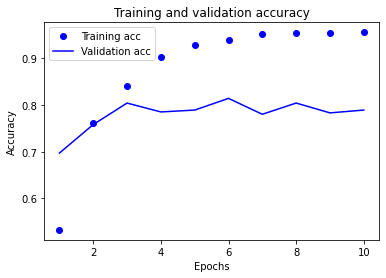

71/71 [==============================] - 1s 9ms/step - loss: 1.1756 - accuracy: 0.7907
['loss', 'accuracy']
[1.1756166219711304, 0.790739119052887]


In [25]:
model = models.Sequential()
model.add(layers.Dense(512, activation='relu', input_shape=(10000,)))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(46, activation='softmax'))

model.compile(optimizer='rmsprop',
             loss='categorical_crossentropy',
             metrics=['accuracy'])

history = model.fit(partial_x_train,
                   partial_y_train,
                   epochs=10,
                   batch_size=512,
                   validation_data=(x_val, y_val))

plt.clf()

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

results = model.evaluate(x_test, one_hot_test_labels)
print(model.metrics_names)
print(results)